<a href="https://colab.research.google.com/github/Tenrog/NREL_Spring_2022_Penultimate.ipynb/blob/Patrick's-Branch/NREL_Spring_2022_Penultimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementing Random Sketching in GMRes**

#Work Breakdown

* Em Gibbs: Main writer, main coder. Organized and composed the notebook. Researched sparse matrix sketching. Tested Spring 2021 sketching functions. Assisted with RGMRes coding.
* Haonan He: Manager, coder. Researched random skething, RGS Arnoldi, and randomized GMRes. Wrote RGMRes code implmentation.
* Patrick Gornet: Main debugger, coder, communicator. Led communication with sponsor. Researched classical GMRes. Wrote classical GMRes implementations. Assisted with RGMRes coding.

#Abstract

When solving linear systems of equations in the form $Ax = b$ where $A$ and $b$ are given, finding the exact value of $x$ for a large-dimension $A$ can be extremely inefficient. Iterative methods like GMRes can speed up this computation time by finding $x$ values that satisfy the equation within a specified margin of error, but are still slow. By introducing random sketching into GMRes, in which $n$ dimensions are randomly embedded into $k$ dimensions such that $k \ll n$, this project hopes to greatly reduce the computation time of $x$.

#Introduction

* When a matrix or vector is sketched, its dimensions are reduced. This is useful since algorithms like GMRes perform many inner products, so reducing the dimensions of the matrices involved in these inner products can reduce the computational effort necessary in each iteration of the algorithm.
* The National Renewable Energy Laboratory (NREL), the sponsor of this project, often works with $A$ matrices with dimensions in the billions. Reducing one of those dimensions by a significant factor will more significantly reduce this computational effort.
* The Spring 2021 Math Clinic NREL team worked on developing an implementation of the Gram-Schmidt process using random sketching, based on the paper "Randomized Gram-Schmidt process with application to GMRES" by Grigori and Balabanov. Since GMRes uses the Modified Gram-Schmidt (MGS), this project aims to implement the Randomized Gram-Schmidt (RGS) in its place, along with other implementations of sketching.
* This project therefore will consider pre-existing implementations and pseudocode of GMRes, modifying them or constructing new implementations suited to integrating the random sketching methods defined in the Grigori & Balabanov paper.
* When an implementation of GMRes with random sketching is fully developed, this project will test this implemenation against other GMRes implementations for computational time and accuracy.

#Methods

##Imports

In [ ]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.lines as line
import plotly.express as px
from tabulate import tabulate

##Random Sketching

Since this project is building off of the work done by the Spring 2021 NREL team, we will be using similar matrices to them for testing. That is, while testing the implementation of RGS, we will use $n$ values in the hundreds or thousands, $m$ values in the tens or hundreds, and $k$ values in between there. If the algorithms run well in these ranges, they should also be applicable to much larger sized matrices.

###Important Functions

The following functions are taken from the Spring 2021 NREL Math Clinic project, and are important for testing later in this section and elsewhere in the notebook.

In [ ]:
#https://colab.research.google.com/drive/1F8fiuN3Qg2zQ0EMobHcCDuuLVlwqkTWv
#Defining important functions

#Defining matrix multiplication function
def mat_mul(x,y):
  return np.matmul(x,y) #AF: coders asked to write a faster code based on Θ structure

#Building Θ Matrix
def Theta_Matrix(k,n): #AF: brute force implementation
  Theta = (np.random.randint(0,2,size=(k,n))*2-1)*math.sqrt(k)**-1
  return Theta

#Finds smallest possible k from inequality 3a using values set above.
def mink(ϵ, d, δ):                           # δ, ϵ are local here
  min_k = 7.87*ϵ**-2*(6.9*d + math.log(1/δ)) #AF: Grigori & Balabanov (3a)
  return min_k

###Balabanov & Grigori Inequality 2.1

The following inequality is defined as Definition 2.1 in the Balabanov and Grigori paper (i.e., the definition of an ϵ-subspace embedding for V):
$$∀x, y∈V; |<x;y> - <Θx;Θy>| ≤ ε||x||⋅||y||$$ 

For a sketching matrix Θ, δ is equal to the failure rate of inequality 2.1.

The following code blocks test various random vectors x and y from V to determine a failure rate δ for inequality 2.1. The function inequality2 is taken from the Spring 2021 NREL Math Clinic project.

By choosing and varying k and d in the generation of the Θ matrix, we hope to discover ε and δ values using the following inequality 2.2a:

$$k≥7.87ε^{-2}(6.9d + log(1/δ))$$

In [ ]:
#https://colab.research.google.com/drive/1F8fiuN3Qg2zQ0EMobHcCDuuLVlwqkTWv

def inequality2(V, d, Θ, ϵ):
  #Getting x and y arrays in V subspace
  a = np.random.normal(0,1,d)
  x_from_V =  mat_mul(V, a)
  b = np.random.normal(0,1,d) 
  y_from_V = mat_mul(V, b)
  #Matrix vector products of Θ and x,y
  theta_x = mat_mul(Θ, x_from_V)
  theta_y = mat_mul(Θ, y_from_V)
  #Calculate right and left hand side of the equation
  LHS = abs(np.inner(x_from_V,y_from_V) - np.inner(theta_x, theta_y))
  RHS = ϵ*np.linalg.norm(x_from_V)*np.linalg.norm(y_from_V)
  #Comparing RHS to LHS   
  if LHS <= RHS:  #AF: I asked to return and inspect (RHS – LHS) to see how close the success is
    return True
  else:
    return False

In [ ]:
#Test function for inequality 2
def test_inequality2(num_iters, V, d, Θ, ϵ):
  passes = 0
  failures = 0
  for i in range(num_iters):
    if inequality2(V, d, Θ, ϵ):
      passes += 1
    else:
      failures += 1

  return failures / (failures + passes)

In [ ]:
#assign variables
n = 5000
ϵ = 1/2
d = [5, 50, 500]
k = [500, 1000, 2000, 4000]

for d_iter in d:
  for k_iter in k:
    #generate theta
    Θ = Theta_Matrix(k_iter, n)
    V = np.random.normal(0, 1, (n, d_iter))

    #iterate test inequality 2.1 100 times
    iter = 100
    failrate = test_inequality2(iter, V, d_iter, Θ, ϵ)

    print("For k = ", k_iter, ", d = ", d_iter, ":")
    print("Failure rate = ", failrate)

For k =  500 , d =  5 :
Failure rate =  0.0
For k =  1000 , d =  5 :
Failure rate =  0.0
For k =  2000 , d =  5 :
Failure rate =  0.0
For k =  4000 , d =  5 :
Failure rate =  0.0
For k =  500 , d =  50 :
Failure rate =  0.0
For k =  1000 , d =  50 :
Failure rate =  0.0
For k =  2000 , d =  50 :
Failure rate =  0.0
For k =  4000 , d =  50 :
Failure rate =  0.0
For k =  500 , d =  500 :
Failure rate =  0.0
For k =  1000 , d =  500 :
Failure rate =  0.0
For k =  2000 , d =  500 :
Failure rate =  0.0
For k =  4000 , d =  500 :
Failure rate =  0.0


The Spring 2021 NREL Math Clinic team also tested several possible values for these variables in the inequality 2.1, but could never get the inequality to fail as long as other necessary inequalities for the variables still held. This seemed strange, as we then have no basis for the selection of δ. However, we can see that these variable tests also produced no failures of the inequality, so we will continue to use the Spring 2021 chosen variable values (δ of 0.9 and ε of 1/2).

###Testing Spring 2021 Randomized Gram-Schmidt

The following functions are taken from the Spring 2021 NREL Math Clinic project. This code block has an implementation of Gram-Schmidt taken from Professor Liu, and their implementation of Randomized Gram-Schmidt (RGS).

In [ ]:
#https://colab.research.google.com/drive/1F8fiuN3Qg2zQ0EMobHcCDuuLVlwqkTWv
'(Liu)'
'Used to compare RGS with classic GS'
def reduced_QR(A):
  """
  Perform reduced QR factorization with Gram Schmidt orthogonalization
  for the columns of Areturn Q: a matrix of size m x n with orthonormal columns
  R: an upper triagular matrix of size n x n
  """
  n, m = A.shape                          #AF: m, n swapped cf. rest of code
  Q = np.zeros((n,m))
  R = np.zeros((m,m))
  for i in range(m):
    y = A[:, i]
    for j in range(i):
      R[j,i] = np.dot(Q[:,j], A[:,i])
      y = y - R[j,i]*Q[:,j]
    R[i,i] = np.linalg.norm(y)
    Q[:,i] = y/R[i,i]

    #print("Reduced QR")
    #print("R[i,i]", R[i,i])
  return Q, R

def rand_QR(A, k):
  #Setting Values                           #AF: B&G Algo. 2 requires m ≤ k << n
  m = A.shape[1]
  n = A.shape[0]
  Θ = Theta_Matrix(k,n)
  #Setting zero matrices to build
  Q = np.zeros((n,m))
  R = np.zeros((m,m))                       #AF: could use sparse structure
  S = np.zeros((k,m))                       #AF: S need not be formed
  p = np.dot(Θ, A)                          #AF: p need not be formed
  for i in range(m):                        #AF: So i here is i–1 in RGS_balabanov_grigori_2020.pdf
    #steps 2, 3:
    if i == 0:
      #step 3
      q_prime_i = A[:,i]
    else:
      new_holder = S[:,i-1]                 #AF: B&G Algo. 2 says S[:,:i] not S[:,i-1]
      new_holder = np.reshape(new_holder, (k,1))
      holder = np.linalg.pinv(new_holder)   #AF: the pinv of a tall S is always (S⸆S)⁻¹S⸆
      r_i = np.dot(holder, p)               #AF: np.linalg.solve(S⸆S,S⸆p) would be faster
      R[i-1,:] = r_i                        #AF: not indexed like B&G Algo. 2 step 2
      q_prime_i = A[:,i] - np.dot(Q, R[:,i])#AF: not indexed like B&G Algo. 2 step 3
    #step 4
    s_prime_i = np.dot(Θ, q_prime_i)
    #step 5
    r = np.linalg.norm(s_prime_i)
    #step 6
    s_i = s_prime_i/r
    #step 7
    q_i = q_prime_i/r
    #Building Q, R, S
    Q[:,i] = q_i
    S[:,i] = s_i
    if i==(m-1):                            #AF: this whole block is some ghastly kluge against above errors
      new_holder = S[:,i]
      new_holder = np.reshape(new_holder, (k,1))
      holder = np.linalg.pinv(new_holder)
      r_i = np.dot(holder, p)
      R[i,:] = r_i
      for k in range(m):
        R[k+1:,k] = 0
  return Q, R, Θ

Additionally, the following function RGS_testing was also taken from the Spring 2021 project, but modified slightly.

In [ ]:
#https://colab.research.google.com/drive/1F8fiuN3Qg2zQ0EMobHcCDuuLVlwqkTWv
#Numerical Stability Test
#iter is number of iterations
def RGS_testing(iter, A, k):
  results = []
  times = []
  for i in range(iter):
    #Performing the QR decompositions and tracking the time
    tic = time.perf_counter()
    GS_Q, GS_R = reduced_QR(A)
    toc = time.perf_counter()
    GS_time = toc - tic
    tic = time.perf_counter()
    RGS_Q, RGS_R, sketch_mat = rand_QR(A, k)
    toc = time.perf_counter()
    RGS_time = toc - tic
    time_diff = GS_time - RGS_time
    #Finding and comparing the accuracy of the two methods
    GS_results = A - mat_mul(GS_Q, GS_R)
    GS_Ortho = np.identity(np.shape(A)[1]) - GS_Q.T @ GS_Q
    RGS_results = A - mat_mul(RGS_Q, RGS_R)
    RGS_Ortho = (sketch_mat @ RGS_Q).T @ sketch_mat @ RGS_Q - np.identity(np.shape(A)[1])
    GS_norm = np.linalg.norm(GS_results)/np.linalg.norm(A)
    RGS_norm = np.linalg.norm(RGS_results)/np.linalg.norm(A)
    GS_Onorm = np.linalg.norm(GS_Ortho)/(np.sqrt(np.shape(A)[1]))
    RGS_Onorm = np.linalg.norm(RGS_Ortho)/(np.sqrt(np.shape(A)[1]))
    accuracy = (GS_norm, RGS_norm, GS_Onorm, RGS_Onorm)
    #Setting results
    results = [GS_norm, RGS_norm, GS_Onorm, RGS_Onorm]
    times.append(time_diff)
  return results, times

The following code comapres runtime and accuracy of GS and last Spring's implementation of RGS.

In [ ]:
#variable declarations
n = 100
m = 50
k = 75

A = np.random.rand(n, m)
iter = 1

#run tests
results, times = RGS_testing(iter, A, k)

#print results
for i in range(iter):
  print("Reduced QR Accuracy: ", results[0])
  print("Rand QR Accuracy: ", results[1])
  print("Reduced QR Orthogonality: ", results[2])
  print("Rand QR Orthogonality: ", results[3])
  print("The time difference was: " + str(times[i]))
  if times[i] < 0:
    print("Gram Schmidt was quicker than RGS here.")
  elif times[i] == 0:
    print("RGS and GS took the same time here.")
  else:
    print("RGS was quicker than GS here.")
  print("\n")

Reduced QR Accuracy:  2.3765860905174157e-16
Rand QR Accuracy:  1.602867893064244e-15
Reduced QR Orthogonality:  2.4540899653727825e-15
Rand QR Orthogonality:  1.0713968484038808e-14
The time difference was: 0.0007449389995599631
RGS was quicker than GS here.




Although the RGS function runs as fast as the MGS function, the accuracy is not as good. Without spending more time working with the code, it is hard to say what is causing this difference in error. There is a similar difference in orthogonality of the Q returned from the functions.

While the Spring 2021 NREL Math Clinic team managed to develop a working Randomized Gram-Schmidt function, there are issues with the accuracy. Additionally, the function is not constructed in a way that is conducive to implementing it into a full RGMRes. Rather than trying to debug and modify the code to work for us, we opted to develop our own implementation of the full RGMRes as described in the Grigori & Balabanov paper.

###Testing Algo_2

We developed our own implementation of randomized GMRes. In doing so, we also developed our own implementation of RGS. This function is defined as algo_2. The following code defines algo_2, as well as a modified RGS_testing function for comparison. The algo_2 function is also defined so that we can easily decide whether to use GMRes with or without sketching.

In [ ]:
#Balabanov & Grigori Algorithm 2 (RGS)
#Parameters: nxm array W, kxn array sketch_mat, boolean sketch
#Returns: nxm factor Q, mxm upper triangular factor R
def algo_2(W, sketch_mat, sketch):
  
    if (sketch):
      def my_sketch(sketch_mat, mat):
        return sketch_mat @ mat
    else:
      def my_sketch(sketch_mat, mat):
        return mat

    #Getting sizes of matrices
    n, m = W.shape
    k = len(sketch_mat)

    #Initializing zero matrices
    S = np.zeros((n,m))
    S = my_sketch(sketch_mat, S)
    Q = np.zeros((n,m))
    R = np.zeros((m,m))

    #RGS Algorithm
    for i in range(m):
        #2.1: Sketch w_i: p_i = Θw_i
        p = my_sketch(sketch_mat, W[:,i])

        q_p = W[:,i]
        #2.2: Solve k x (i-1) least-squares problem:
        #   R_1:i-1,i = arg min_y ||(S_i-1)y - p_i||
        #   pinv method
        S_pinv = np.linalg.pinv(S[:,:i])
        R[:i,i] = S_pinv @ p
        #   lstsq method
        #R[:i,i] = np.linalg.lstsq(S[:,:i],p)
        #   fournier method
        #S_sub = S[:,:i]
        #StS = np.dot(S_sub.transpose(),S_sub)
        #Stp = np.dot(S_sub.transpose(), p)
        #R[:i,i] = np.linalg.solve(StS, Stp)
        #2.3: Compute projection of w_i: q_i_p = w_i - (Q_i-1)R_1:i-1,i
        q_p = q_p - np.dot(Q[:,:i],R[:i,i])
        #2.4: Sketch q_i_p: s_i_p = Θq_i_p
        s_p = my_sketch(sketch_mat, q_p)
        #2.5: Compute the sketched norm r_i,i = ||s_i_p||
        R[i,i] = np.linalg.norm(s_p)
        #2.6: Scale vector s_i = s_i_p/r_i.i
        S[:,i] = s_p/R[i,i]
        #2.7: Scale vector q_i = q_i_p/r_i.i
        Q[:,i] = q_p/R[i,i]
    return Q, R

def RGS_testing_2(iter, W, k):
    sketch = True

    results = []
    times = []
    for i in range(iter):
        sketch_mat=Theta_Matrix(k,n)
        tic = time.perf_counter()
        GS_Q, GS_R = reduced_QR(W)
        toc = time.perf_counter()
        GS_time = toc - tic
        tic = time.perf_counter()
        RGS_Q, RGS_R = algo_2(W, sketch_mat, sketch)
        toc = time.perf_counter()
        RGS_time = toc - tic
        time_diff = GS_time - RGS_time
    #Finding and comparing the accuracy of the two methods
        GS_results = W - mat_mul(GS_Q, GS_R)
        GS_Ortho = np.identity(np.shape(W)[1]) - GS_Q.T @ GS_Q
        RGS_results = W - mat_mul(RGS_Q, RGS_R)
        RGS_Ortho = (sketch_mat @ RGS_Q).T @ sketch_mat @ RGS_Q - np.identity(np.shape(W)[1])
        GS_norm = np.linalg.norm(GS_results)/np.linalg.norm(W)
        RGS_norm = np.linalg.norm(RGS_results)/np.linalg.norm(W)
        GS_Onorm = np.linalg.norm(GS_Ortho)/(np.sqrt(np.shape(W)[1]))
        RGS_Onorm = np.linalg.norm(RGS_Ortho)/(np.sqrt(np.shape(W)[1]))
        accuracy = (GS_norm, RGS_norm, GS_Onorm, RGS_Onorm)
    #Setting results
        results.append(accuracy)
        times.append(time_diff)
    return results, times

The following code defines testing functions for algo_2.

In [ ]:
def AllGS_testing(A, k):
  sketch_mat=Theta_Matrix(k,np.shape(A)[0])
  #Performing the QR decompositions and tracking the time
  GS_Q, GS_R = reduced_QR(A)
  RGS_Q, RGS_R, Θ = rand_QR(A, k)
  ALGO_Q, ALGO_R = algo_2(A, sketch_mat, False)
  SALGO_Q, SALGO_R = algo_2(A, sketch_mat, True)

  #Finding and comparing the accuracy of the two methods
  GS_results = A - mat_mul(GS_Q, GS_R)
  GS_Ortho = np.identity(np.shape(A)[1]) - GS_Q.T @ GS_Q
  RGS_results = A - mat_mul(RGS_Q, RGS_R)
  RGS_Ortho = (Θ @ RGS_Q).T @ Θ @ RGS_Q - np.identity(np.shape(A)[1])
  ALGO_results = A - mat_mul(ALGO_Q, ALGO_R)
  ALGO_Ortho = np.identity(np.shape(A)[1]) - ALGO_Q.T @ ALGO_Q
  SALGO_results = A - mat_mul(SALGO_Q, SALGO_R)
  SALGO_Ortho = (sketch_mat @ SALGO_Q).T @ sketch_mat @ SALGO_Q - np.identity(np.shape(A)[1])



  GS_norm = np.linalg.norm(GS_results)/np.linalg.norm(A)
  GS_Onorm = np.linalg.norm(GS_Ortho)/(np.sqrt(np.shape(A)[1]))
  RGS_norm = np.linalg.norm(RGS_results)/np.linalg.norm(A)
  RGS_Onorm = np.linalg.norm(RGS_Ortho)/(np.sqrt(np.shape(A)[1]))
  ALGO_norm = np.linalg.norm(ALGO_results)/np.linalg.norm(A)
  ALGO_Onorm = np.linalg.norm(ALGO_Ortho)/(np.sqrt(np.shape(A)[1]))
  SALGO_norm = np.linalg.norm(SALGO_results)/np.linalg.norm(A)
  SALGO_Onorm = np.linalg.norm(SALGO_Ortho)/(np.sqrt(np.shape(A)[1])) 

  data = [["reduced_QR", "No", GS_norm, GS_Onorm],
  ["algo_2", "No", ALGO_norm, ALGO_Onorm],
  ["rand_QR", "Yes", RGS_norm, RGS_Onorm],
  ["algo_2", "Yes", SALGO_norm, SALGO_Onorm]]
  print (tabulate(data, headers=["Algorithm", "Sketching?", "Accuracy", "Orthogonality"]))
  return data

The following code tests algo_2 against reduced_QR and rand_QR.

In [ ]:
n = 350
m = 250
k = 300
W = np.random.rand(n, m)
#run tests
print("A = (", n, "x", m, ")")
print("k = ", k)
data = AllGS_testing(W, k)
print()

A = ( 350 x 250 )
k =  300
Algorithm    Sketching?       Accuracy    Orthogonality
-----------  ------------  -----------  ---------------
reduced_QR   No            5.25316e-16      1.42545e-14
algo_2       No            5.07608e-16      5.16546e-15
rand_QR      Yes           6.00632e-15      7.81891e-14
algo_2       Yes           5.3334e-16       0.0786778



We can see that our non-sketching algo_2 implementation has accuracy comparable to the reduced_QR by Professor Liu, and the Q returned by the function is even closer to orthogonal than the other implementations. The sketching version of algo_2 has accuracy better than rand_QR by last Spring's team, and once again is closer to orthogonal than it. We can then surmise that we've developed a very accurate implementation of Randomized Gram Schmidt as defined by Grigori and Balabanov.

##Randomized GMRes

###Grigori & Balabanov Algorithms

The randomized GMRes implementation developed was based on the following two algorithms from the Grigori & Balabanov paper, along with the following minimization step to calculate a new guess after each iteration.

<img src='https://i.imgur.com/ewbMXkZ.png'>

<img src='https://i.imgur.com/bVKQtyD.png'>

<img src='https://i.imgur.com/9gxHgff.png'>

Given the above algorithms, and using the Sauer GMRes implementation to guide the logic of this implementation's development, the following randomized GMRes was developed.

###Randomized GMRes Implementation

The following function is the minimization step of the randomized GMRes algorithm.

In [ ]:
#Parameters: arrays A, Q, R, sketch_mat
#Returns: array x
def find_x(A, Q, R, sketch_mat):
    #Getting sizes of matrices
    n = len(Q)
    m = len(Q[0])

    #Minimize function
    b = np.zeros((m,1))
    b[0] = R[0,0]

    sketched_AQ = my_sketch(sketch_mat, A)
    sketched_AQ = np.dot(sketched_AQ, Q[:,:m])
    sketched_b = np.dot(my_sketch(sketch_mat, Q), b)

    y = np.linalg.lstsq(sketched_AQ, sketched_b)[0]

    x = np.dot(Q[:,:m],y)

    return x

The following code is a test case of the above find_x function.

In [ ]:
def test_find_x():
  sketch = True
  if (sketch):
    def my_sketch(sketch_mat, mat):
      return sketch_mat @ mat
  else:
    def my_sketch(sketch_mat, mat):
      return mat

  A = np.array([[1,2],[3,4]])
  Q = np.identity(2)
  B = A @ Q
  x = np.array([[B[1,1],-B[1,0]]]).T
  print("x True")
  print(x)
  b = B @ x
  result = find_x(A, Q, np.array([b[0]]), np.array([[6,7],[8,9]]))
  print("Calculated x")
  print(result)

In [ ]:
test_find_x()

x True
[[ 4.]
 [-3.]]
Calculated x
[[ 4.]
 [-3.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


Since this (brief) test of find_x returned the exact same result as the expected x, we can surmise it runs correctly.

The following code implements randomized GMRes using algo_2 and find_x.

In [ ]:
#RGS-Arnoldi GMRes
#Parameters: nxm array A, nx1 array b, kxn array sketch_mat, bool sketch
#Returns: nxm factor array Q_m, mxm upper triangular factor R_m, result array X
def my_random_gmres(A, b, x_true, sketch_mat, sketch = False, err_tol = 1e-8):

    #Getting sizes of matrices
    n = len(A)
    m = len(A[0])

    #3.1: Set w_1 = b
    W = b
    #3.2: Perform 1st iteration of Algorithm 2
    Q, R = algo_2(W, sketch_mat, sketch)

    for i in range(1, m):
        #3.3: Compute w_i = Aq_i-1
        w_i = np.dot(A,Q[:,[i-1]])
        W = np.hstack((W, w_i))

        #3.4: Perform i-th iteration of Algorithm 2
        Q, R = algo_2(W, sketch_mat, sketch)

        #Minimize step to find next x guess
        x = find_x(A, Q, R, sketch_mat)

        #Error tolerance test
        #curr_err = sum(abs(x_true - x))
        #print(i+1, curr_err)
        #if curr_err < err_tol:
        #    return Q, R, x, i+1

    return Q, R, x, i+1

The following code tests my_random_gmres.

In [ ]:
n = 20
k = 20
#np.random.seed(11)
A = np.random.rand(n,n)
x_true = np.random.rand(n,1)
x_true /= np.linalg.norm(x_true)
b = np.dot(A,x_true)
sketch_mat = Theta_Matrix(k,n)
sketch = True

if (sketch):
  def my_sketch(sketch_mat, mat):
    return sketch_mat @ mat
else:
  def my_sketch(sketch_mat, mat):
    return mat

Q, R, x, iter = my_random_gmres(A, b, x_true, sketch_mat, sketch)
print("x True")
print(x_true.T)
print("RGMRes x")
print(x.T)
print("GMRes Error")
print((x_true - x).T)
print("GMRes sum(abs(error))")
print(sum(abs(x_true - x)))

x True
[[0.10340212 0.19540893 0.0522525  0.03919367 0.32534822 0.33989577
  0.26399068 0.25060782 0.0059231  0.16574397 0.27563477 0.14169302
  0.04825621 0.40494473 0.03780138 0.2923374  0.10849784 0.35418526
  0.26960837 0.07947763]]
RGMRes x
[[0.10340212 0.19540893 0.0522525  0.03919367 0.32534822 0.33989577
  0.26399068 0.25060782 0.0059231  0.16574397 0.27563477 0.14169302
  0.04825621 0.40494473 0.03780138 0.2923374  0.10849784 0.35418526
  0.26960837 0.07947763]]
GMRes Error
[[-2.23709939e-14 -1.51073598e-13 -6.07708328e-14  2.55052923e-13
  -3.63042929e-14 -1.72861725e-13  2.49189558e-13  1.25732758e-13
   5.99095426e-14  2.08832951e-13 -1.42219569e-13  1.14158683e-13
  -1.25635613e-13 -7.03881398e-14  1.16087695e-14  2.59792188e-14
  -1.47604151e-13  1.92068583e-13 -6.07847106e-14 -2.21780927e-13]]
GMRes sum(abs(error))
[2.45432754e-12]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


This GMRes implementation works consistently when sketching is not involved, but has issues when it is. When k = n, this implementation runs very well most of the time, though sometimes runs into failures.

#Results & Discussion

## Randomized GMRes Testing

Note: For the following code blocks, this error may appear:

ValueError: On entry to DLASCL parameter number 4 had an illegal value

If this error appears, simply try running the code again, as it is a known bug and not an issue with our code.

Testing failures of GMRes with sketching for k = n at several different k, n values.

Note: The code below took several minutes to run on last execution.

In [ ]:
n_list = [5, 10, 20, 50, 100]
norm_errs = np.zeros((len(n_list),10))

sketch = True

if (sketch):
  def my_sketch(sketch_mat, mat):
    return sketch_mat @ mat
else:
  def my_sketch(sketch_mat, mat):
    return mat

h = 0
for n in n_list:
  for i in range(len(norm_errs[0])):
    A = np.random.rand(n,n)
    x_true = np.random.rand(n,1)
    x_true /= np.linalg.norm(x_true)
    b = np.dot(A,x_true)
    sketch_mat = Theta_Matrix(n,n)
    Q, R, x, iter = my_random_gmres(A, b, x_true, sketch_mat, sketch)
    norm_errs[h,i] = sum(abs(x_true - x))
  h = h + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


The following code prints a plot of the failure rates of GMRes with sketching (when k = n) for several n values.

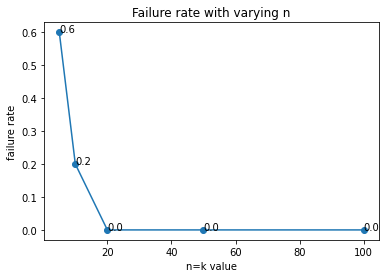

In [ ]:
failures = np.zeros(len(norm_errs))

for i in range(len(norm_errs)):
  for j in range(len(norm_errs[i])):
    if norm_errs[i,j] > 1e-5:
      failures[i] = failures[i] + 1

percent_failures = failures/10

plt.scatter(n_list, percent_failures)
plt.plot(n_list, percent_failures, linestyle="solid")
plt.title("Failure rate with varying n")
plt.xlabel("n=k value")
plt.ylabel("failure rate")
for i, val in enumerate(percent_failures):
  plt.annotate(val, (n_list[i], percent_failures[i]))

As we can see by this, when k = n and n is sufficiently large, this GMRes implementation with sketching rarely if ever fails.

The following code does the same as the above two code blocks, but for k < n.

In [ ]:
n_list = [5, 10, 20, 50, 100]
norm_errs = np.zeros((len(n_list),10))

sketch = True

if (sketch):
  def my_sketch(sketch_mat, mat):
    return sketch_mat @ mat
else:
  def my_sketch(sketch_mat, mat):
    return mat

h = 0
for n in n_list:
  for i in range(len(norm_errs[0])):
    k = n - 1
    A = np.random.rand(n,n)
    x_true = np.random.rand(n,1)
    x_true /= np.linalg.norm(x_true)
    b = np.dot(A,x_true)
    sketch_mat = Theta_Matrix(k,n)
    Q, R, x, iter = my_random_gmres(A, b, x_true, sketch_mat, sketch)
    norm_errs[h,i] = sum(abs(x_true - x))
  h = h + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


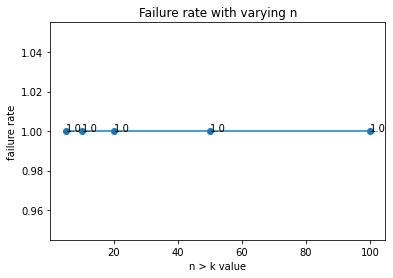

In [ ]:
failures = np.zeros(len(norm_errs))

for i in range(len(norm_errs)):
  for j in range(len(norm_errs[i])):
    if norm_errs[i,j] > 1e-5:
      failures[i] = failures[i] + 1

percent_failures = failures/10

plt.scatter(n_list, percent_failures)
plt.plot(n_list, percent_failures, linestyle="solid")
plt.title("Failure rate with varying n")
plt.xlabel("n > k value")
plt.ylabel("failure rate")
for i, val in enumerate(percent_failures):
  plt.annotate(val, (n_list[i], percent_failures[i]))

As we can see by the plot above, when k < n, the random GMRes algorithm fails every time. Given the fact that both algo_2 and find_x run properly with sketching k < n, we are not sure why this failure happens at this point, and we will continue to look into it.

The following code does the same as the code above, but without sketching.

In [ ]:
n_list = [5, 10, 20, 50, 100]
norm_errs = np.zeros((len(n_list),10))

sketch = False

if (sketch):
  def my_sketch(sketch_mat, mat):
    return sketch_mat @ mat
else:
  def my_sketch(sketch_mat, mat):
    return mat

h = 0
for n in n_list:
  for i in range(len(norm_errs[0])):
    A = np.random.rand(n,n)
    x_true = np.random.rand(n,1)
    x_true /= np.linalg.norm(x_true)
    b = np.dot(A,x_true)
    sketch_mat = Theta_Matrix(n,n)
    Q, R, x, iter = my_random_gmres(A, b, x_true, sketch_mat, sketch)
    norm_errs[h,i] = sum(abs(x_true - x))
  h = h + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


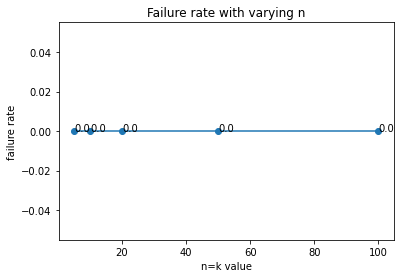

In [ ]:
failures = np.zeros(len(norm_errs))

for i in range(len(norm_errs)):
  for j in range(len(norm_errs[i])):
    if norm_errs[i,j] > 1e-5:
      failures[i] = failures[i] + 1

percent_failures = failures/10

plt.scatter(n_list, percent_failures)
plt.plot(n_list, percent_failures, linestyle="solid")
plt.title("Failure rate with varying n")
plt.xlabel("n=k value")
plt.ylabel("failure rate")
for i, val in enumerate(percent_failures):
  plt.annotate(val, (n_list[i], percent_failures[i]))

As we can see by the above code, when sketching is not being used, the algorithm never fails.

## Algo 2 Function Testing

The following code tests algo_2 with and without sketching. With sketching, the code tests algo_2 for several n values and k values. Without sketching, the code tests algo_2 for several n values and m values.

In [ ]:
def m_list(n):
  m = []
  m.append(np.ceil(n * 0.2))
  m.append(np.ceil(n * 0.5))
  m.append(np.ceil(n * 0.8))
  m.append(np.ceil(n))
  return m
def k_list(n):
  k = []
  k.append(np.ceil(n * 0.2))
  k.append(np.ceil(n * 0.50))
  k.append(np.ceil(n* 0.8))
  k.append(n)
  return k

  # Function outputs 3D Array of truples categorized as such: [n value, m value, iteration] = (accuracy, orthogonality)
def Algo2_Testing(n_list, trials):
  def algo_Results(A):
    sketch_mat = np.identity(n)
    ALGO_Q, ALGO_R = algo_2(A, sketch_mat, False)
    ALGO_results = A - mat_mul(ALGO_Q, ALGO_R)
    ALGO_Ortho = np.identity(np.shape(A)[1]) - ALGO_Q.T @ ALGO_Q
    ALGO_norm = np.linalg.norm(ALGO_results)/np.linalg.norm(A)
    ALGO_Onorm = np.linalg.norm(ALGO_Ortho)/(np.sqrt(np.shape(A)[1]))
    return (ALGO_norm, ALGO_Onorm)
  Algo = []
  for n in n_list:
    l = []
    sketch_mat = np.identity(n)
    for m in m_list(n):
      i = []
      A = np.random.rand(int(n), int(m))
      for t in range(trials):
        i.append(algo_Results(A))
      l.append(i)
    Algo.append(l)
  return Algo


# Function outputs 3D Array of truples categorized as such: [n value, k value, iteration] = (accuracy, orthogonality)
# The m value is always equal to the lowest k value used.
def SAlgo2_Testing(n_list,trials):
  def salgo_Results(A, sketch_mat):
    SALGO_Q, SALGO_R = algo_2(A, sketch_mat, True)
    SALGO_results = A - mat_mul(SALGO_Q, SALGO_R)
    SALGO_Ortho = (sketch_mat @ SALGO_Q).T @ sketch_mat @ SALGO_Q - np.identity(np.shape(A)[1])
    SALGO_norm = np.linalg.norm(SALGO_results)/np.linalg.norm(A)
    SALGO_Onorm = np.linalg.norm(SALGO_Ortho)/(np.sqrt(np.shape(A)[1]))
    return (SALGO_norm, SALGO_Onorm)
  SAlgo = []
  for n in n_list:
    l = []
    sketch_mat = np.identity(n)
    k_lst = k_list(n)
    m = min(k_lst)
    for k in k_lst:
      i = []
      A = np.random.rand(int(n), int(m))
      sketch_mat=Theta_Matrix(int(k),int(n))
      for t in range(trials):
        i.append(salgo_Results(A, sketch_mat))
      l.append(i)
    SAlgo.append(l)
  return SAlgo

In [ ]:
classic_results = (Algo2_Testing([50,100,250,500], 1))
sketch_results = (SAlgo2_Testing([50,100,250,500], 1))

The following code plots errors for several n and m values without sketching.

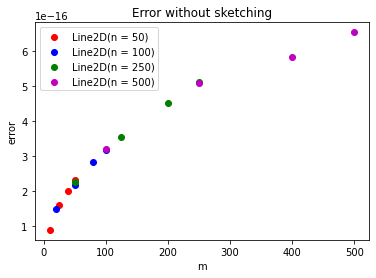

In [ ]:
n_list = [50,100,250,500]
acc = np.zeros((len(n_list),len(n_list)))

p = 0
for n in classic_results:
  q = 0
  for m in n:
    for i in m:
      acc[p,q] = i[0]
    q = q + 1
  p = p + 1

colors = ["r","b","g","m"]

for i in range(len(n_list)):
  m = m_list(int(n_list[i]))
  plt.scatter(m, acc[i], c=colors[i])

plt.legend([line.Line2D([0],[0],marker='o',color='w',label='n = 50', markerfacecolor='r', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 100', markerfacecolor='b', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 250', markerfacecolor='g', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 500', markerfacecolor='m', markersize=10)])

plt.title("Error without sketching")
plt.xlabel("m")
plt.ylabel("error")

plt.show()

The shape of this plot is deceiving, but in general it shows how the error does get slightly larger as $n$ and $m$ increase. However, note that all these values are below $1e-16$, so hey are still extremely small errors.

The following code plots errors for several n and k values with sketching.

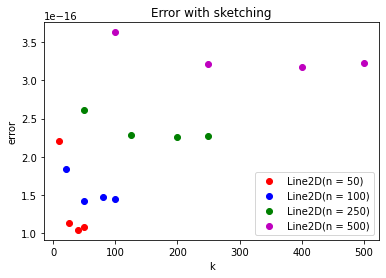

In [ ]:
n_list = [50,100,250,500]
acc = np.zeros((len(n_list),len(n_list)))

p = 0
for n in sketch_results:
  q = 0
  for m in n:
    for i in m:
      acc[p,q] = i[0]
    q = q + 1
  p = p + 1

colors = ["r","b","g","m"]

for i in range(len(n_list)):
  m = m_list(int(n_list[i]))
  plt.scatter(m, acc[i], c=colors[i])

plt.legend([line.Line2D([0],[0],marker='o',color='w',label='n = 50', markerfacecolor='r', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 100', markerfacecolor='b', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 250', markerfacecolor='g', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='n = 500', markerfacecolor='m', markersize=10)])

plt.title("Error with sketching")
plt.xlabel("k")
plt.ylabel("error")

plt.show()

This plot interestingly has a different shape than the previous one, and an unexpected one. The error sometimes decreases and sometimes increases as the k value increases. This may be due to the nature of sketching, but is noteworthy nonetheless.

The following code tests the failure rate for algo_2 after many tests, with several n values.

In [ ]:
def failure_testing_algo(n_list = [50,100,250,500], it = 10, sketch = False):
  if sketch:
    print("Testing Algo 2 with sketching")
    results = SAlgo2_Testing(n_list, it)
  else:
    print("Testing Algo 2 without sketching")
    results = Algo2_Testing(n_list, it)
  
  A_fail = 0
  O_fail = 0
  total = 0
  A_thresh = 1e-10
  O_thresh = 1e-10
  for n in results:
    for m in n:
      for i in m:
        total += 1
        if i[0] > A_thresh:
          A_fail += 1
        if i[1] > O_thresh:
          O_fail += 1
  print("Total number of operations: ")
  print(total)
  print("Operations with error over ", A_thresh)
  print("{0:.0%}".format(A_fail/total))
  print("Operations with orthogonality over ", O_thresh)
  print("{0:.0%}".format(O_fail/total))
  print()

failure_testing_algo(it = 15)
failure_testing_algo(it = 15, sketch = True)

Testing Algo 2 without sketching
Total number of operations: 
240
Operations with error over  1e-10
0%
Operations with orthogonality over  1e-10
0%

Testing Algo 2 with sketching
Total number of operations: 
240
Operations with error over  1e-10
0%
Operations with orthogonality over  1e-10
0%



#Conclusion

The issues from our predecesores was difficult to resolve, but in a few cases we were able to uncover hidden successes such as last spring's randomized Gram-Schmidt which was previously beleived to not produce an orthagonal result but only becasue they we're calculated it's orthagonality relitive to the dot product of the theta sketching matrix. We are proud of that face that we have a functioning GMRes code and it's interesting to see that when using it with sketching we received great results when k = n but mixed resutls when k < n. This inconsitency is baffling but we are as sure as we can be that our algo 2 and find_x functions have no issues, so we suspect the issues lies with the make up of the theta matrix it's self. We beleive our work has created the strongest foundation yet for future classes to work off of and we encourge those how follow to use our work to continue to investigate these complex algorithms and further research into this area.

#Bibliography

Balabanov, O., & Grigori, L. (2022, January 18). *Randomized Gram-Schmidt process with applications to GMRes.* https://arxiv.org/abs/2011.05090

Batchelder, W., Matrinez, V., & Vue, J. *NREL - rGS Project.* https://colab.research.google.com/drive/1F8fiuN3Qg2zQ0EMobHcCDuuLVlwqkTWv

Sauer, T. (2018). Generalized Minimum Residual (GMRES) Method. *Numerical Analysis* (3rd ed. pp. 235-239). Pearson.

Wikimedia Foundation. (2022, Feburary 22). *Generalized minimal residual method.* Wikipedia. https://en.wikipedia.org/wiki/Generalized_minimal_residual_method